The goal here is to evaluate the errors introduced adversarial training by a analyzing the added noise

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [2]:
origWeights = np.load('origWeights.npy')
modifiedWeights = np.load('modifiedWeights.npy')
origBiases = np.load('origBiases.npy')
modifiedBiases = np.load('modifiedBiases.npy')

In [3]:
def compute_minAndMax(listArrays):
    '''
    Function to find the smallest and largest elements 
    in a list of numpy arrays
    '''
    minVal = np.inf
    maxVal = -np.inf
    for arr in listArrays:
        if arr.min() < minVal:
            minVal = arr.min()
        if arr.max() > maxVal:
            maxVal = arr.max()
    return minVal, maxVal

In [4]:
def measure_noise(origValues, modifiedValues):
    noiseValues = []
    for origArr, modifiedArr in zip(origValues, modifiedValues):
        # error_arr is the element-wise difference of all values in the array
        errorArr = origArr - modifiedArr
        noiseValues.append(errorArr)
    return noiseValues

In [5]:
# mnist images are grayscale, so the depth is 1. In cifar10, depth is 3.
# The first 5 layers are convolutional layers in case of cifar10 while 
# only the first 3 are in case of mnist.
if origWeights[0].shape[2] == 1:
    numConvLayers = 3
else:
    numConvLayers = 5
r = measure_noise(origWeights[:numConvLayers], modifiedWeights[:numConvLayers])
min_noise, max_noise = compute_minAndMax(r)
print(min_noise, max_noise)

-0.0019579008 0.00204432


In [6]:
for layer in r:
    print(layer.T.shape)
allMatrices = []
colors = []
if numConvLayers == 3:
    color = ['r', 'g', 'b']
else:
    color = ['r', 'g', 'b', 'y', 'c']

for layer,c in zip(r,color):
    for filter in layer.T:
        for matrix in filter:
            allMatrices.append(matrix.flatten())
            colors.append(c)
allMatrices_tsne = TSNE(n_components=2, perplexity=100, n_iter=1200).fit_transform(allMatrices)
print(allMatrices_tsne.shape)

(32, 1, 3, 3)
(64, 32, 3, 3)
(64, 64, 3, 3)
(6176, 2)


Text(0.5, 1.0, 'Model Noise')

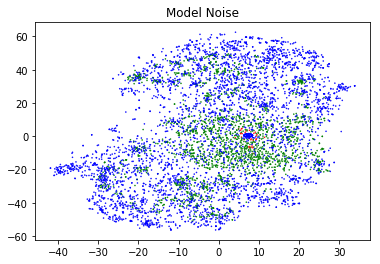

In [7]:
allMatrices_x, allMatrices_y = allMatrices_tsne.T
#plt.figure(figsize=(20,20))
plt.scatter(allMatrices_x, allMatrices_y, s=0.3, c=colors)
plt.title('Model Noise')

Text(0.5, 1.0, 'Model Noise')

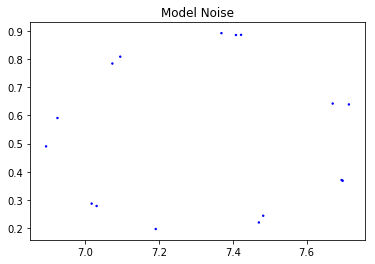

In [44]:
# Code to isolate the circular pattern from the plot
# Using 4 threshold values, I isolate the rectangular 
# region of the plot which contains the circular pattern
x_range = (6.5,8)
y_range = (0,1)
indices = (allMatrices_x < x_range[1]) * (allMatrices_y < y_range[1]) * \
(allMatrices_x > x_range[0]) * (allMatrices_y > y_range[0])

# Plot the isolated pattern to verify that circular pattern 
# was correctly isolated
colors = np.array(colors)
plt.scatter(allMatrices_x[indices], allMatrices_y[indices], c = colors[indices], s=2)
plt.title('Model Noise')

In [45]:
len(np.nonzero(indices)[0])

16

In [46]:
np.nonzero(indices)[0]

array([2498, 3073, 4513, 4518, 4523, 4524, 4529, 4530, 4537, 4551, 4553,
       4555, 4557, 4561, 4563, 4569])

In [50]:
allMatrices[4518]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [13]:
allRandom = []
for i in range(6176):
    randomFilter = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    allRandom.append(randomFilter.flatten())
allRandom_tsne = TSNE(n_components=2, perplexity=40, n_iter=1200).fit_transform(allRandom)

Text(0.5, 1.0, 'Random Noise')

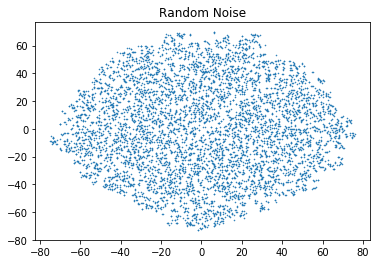

In [14]:
allRandom_x, allRandom_y = allRandom_tsne.T
plt.scatter(allRandom_x, allRandom_y, s=0.3)
plt.title('Random Noise')

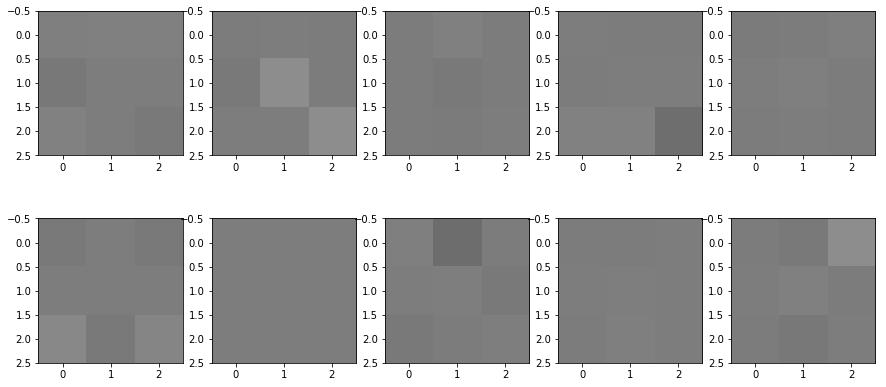

In [16]:
H = np.transpose(r[2])
f, axarr = plt.subplots(2,5, figsize=(15,7))
for num in range(10):
    axarr[num//5][num%5].imshow(H[num][0], cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()

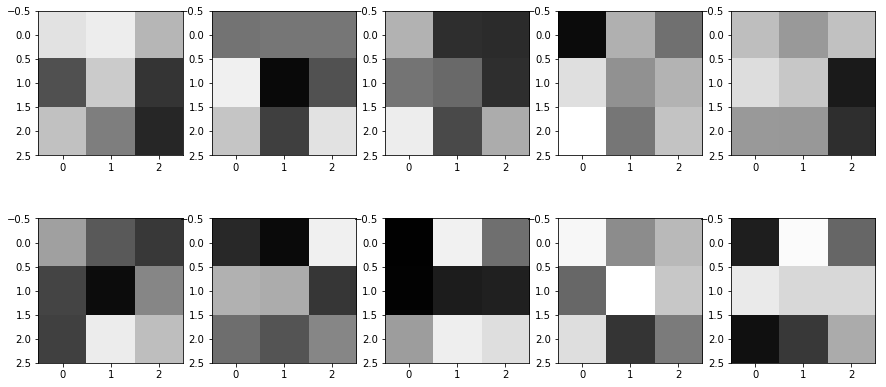

In [17]:
f, axarr = plt.subplots(2,5, figsize=(15,7))
for num in range(10):
    H = (max_noise - min_noise) * np.random.random((3,3)) + min_noise
    axarr.ravel()[num].imshow(H, cmap='gray', vmin=min_noise, vmax=max_noise)
plt.show()